Análise de Sentimentos em Resenhas de Filmes

## Instrução do Projeto

A Film Junky Union (empresa fictícia), uma nova comunidade para entusiastas de filmes clássicos, está desenvolvendo um sistema para filtrar e categorizar resenhas de filmes.

O objetivo é treinar um modelo para detectar automaticamente resenhas negativas. Você usará um conjunto de dados de resenhas de filmes do IMDB com rotulagem de polaridade para criar um modelo para classificar resenhas como positivas e negativas.

Ele precisará ter um valor F1 de pelo menos 0,85.

---

## 1. Inicialização e Imports Completos

In [1]:
# Importação das bibliotecas necessárias

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import math
import spacy

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords as nltk_stopwords
from nltk.stem import WordNetLemmatizer

from sklearn.dummy import DummyClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score
import sklearn.metrics as metrics

from lightgbm import LGBMClassifier

import torch
import transformers
from transformers import BertTokenizer

from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

print("Bibliotecas carregadas com sucesso!")

Bibliotecas carregadas com sucesso!


In [2]:
# Downloads NLTK
nltk.download('punkt_tab', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)

# Configurar barra de progresso para pandas
tqdm.pandas()


## 2. Carregar Dados

In [3]:
df_reviews = pd.read_csv('https://practicum-content.s3.us-west-1.amazonaws.com/datasets/imdb_reviews.tsv',
                         sep='\t', dtype={'votes': 'Int64'})
print(f"Dataset carregado: {df_reviews.shape[0]} resenhas")
df_reviews.head()

Dataset carregado: 47331 resenhas


,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx
0,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,The pakage implies that Warren Beatty and Gold...,1,neg,0,train,8335
1,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,How the hell did they get this made?! Presenti...,1,neg,0,train,8336
2,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,There is no real story the film seems more lik...,3,neg,0,test,2489
3,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,Um .... a serious film about troubled teens in...,7,pos,1,test,9280
4,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,I'm totally agree with GarryJohal from Singapo...,9,pos,1,test,9281


## 3. Análise Exploratória de Dados (EDA)

In [4]:
# Informações do dataset
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47331 entries, 0 to 47330
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tconst           47331 non-null  object 
 1   title_type       47331 non-null  object 
 2   primary_title    47331 non-null  object 
 3   original_title   47331 non-null  object 
 4   start_year       47331 non-null  int64  
 5   end_year         47331 non-null  object 
 6   runtime_minutes  47331 non-null  object 
 7   is_adult         47331 non-null  int64  
 8   genres           47331 non-null  object 
 9   average_rating   47329 non-null  float64
 10  votes            47329 non-null  Int64  
 11  review           47331 non-null  object 
 12  rating           47331 non-null  int64  
 13  sp               47331 non-null  object 
 14  pos              47331 non-null  int64  
 15  ds_part          47331 non-null  object 
 16  idx              47331 non-null  int64  
dtypes: Int64(1),

In [5]:
# Verificar valores ausentes
print("Valores ausentes por coluna:")
print(df_reviews.isna().sum())
print(f"\nTotal de valores ausentes: {df_reviews.isna().sum()}")

Valores ausentes por coluna:
tconst             0
title_type         0
primary_title      0
original_title     0
start_year         0
end_year           0
runtime_minutes    0
is_adult           0
genres             0
average_rating     2
votes              2
review             0
rating             0
sp                 0
pos                0
ds_part            0
idx                0
dtype: int64

Total de valores ausentes: tconst             0
title_type         0
primary_title      0
original_title     0
start_year         0
end_year           0
runtime_minutes    0
is_adult           0
genres             0
average_rating     2
votes              2
review             0
rating             0
sp                 0
pos                0
ds_part            0
idx                0
dtype: int64


In [6]:
# Como foram encontrados apenas 2 valores ausentes, podemos excluir as linhas sem causar prejuízos
df_reviews.dropna(inplace=True)
print(f"Dataset após remoção de valores ausentes: {df_reviews.shape[0]} resenhas")

Dataset após remoção de valores ausentes: 47329 resenhas


In [7]:
# Verificar duplicados
duplicados = df_reviews.duplicated().sum()
print(f"Número de linhas duplicadas: {duplicados}")

Número de linhas duplicadas: 0


In [8]:
# Verificando o balanceamento das avaliações
print("Distribuição de polaridade (pos):")
print(df_reviews['pos'].value_counts())
print(f"\nPercentual de resenhas positivas: {df_reviews['pos'].mean()*100:.1f}%")

Distribuição de polaridade (pos):
pos
0    23715
1    23614
Name: count, dtype: int64

Percentual de resenhas positivas: 49.9%


### 3.1. Visualizações

Vamos verificar o número de filmes e resenhas ao longo dos anos.

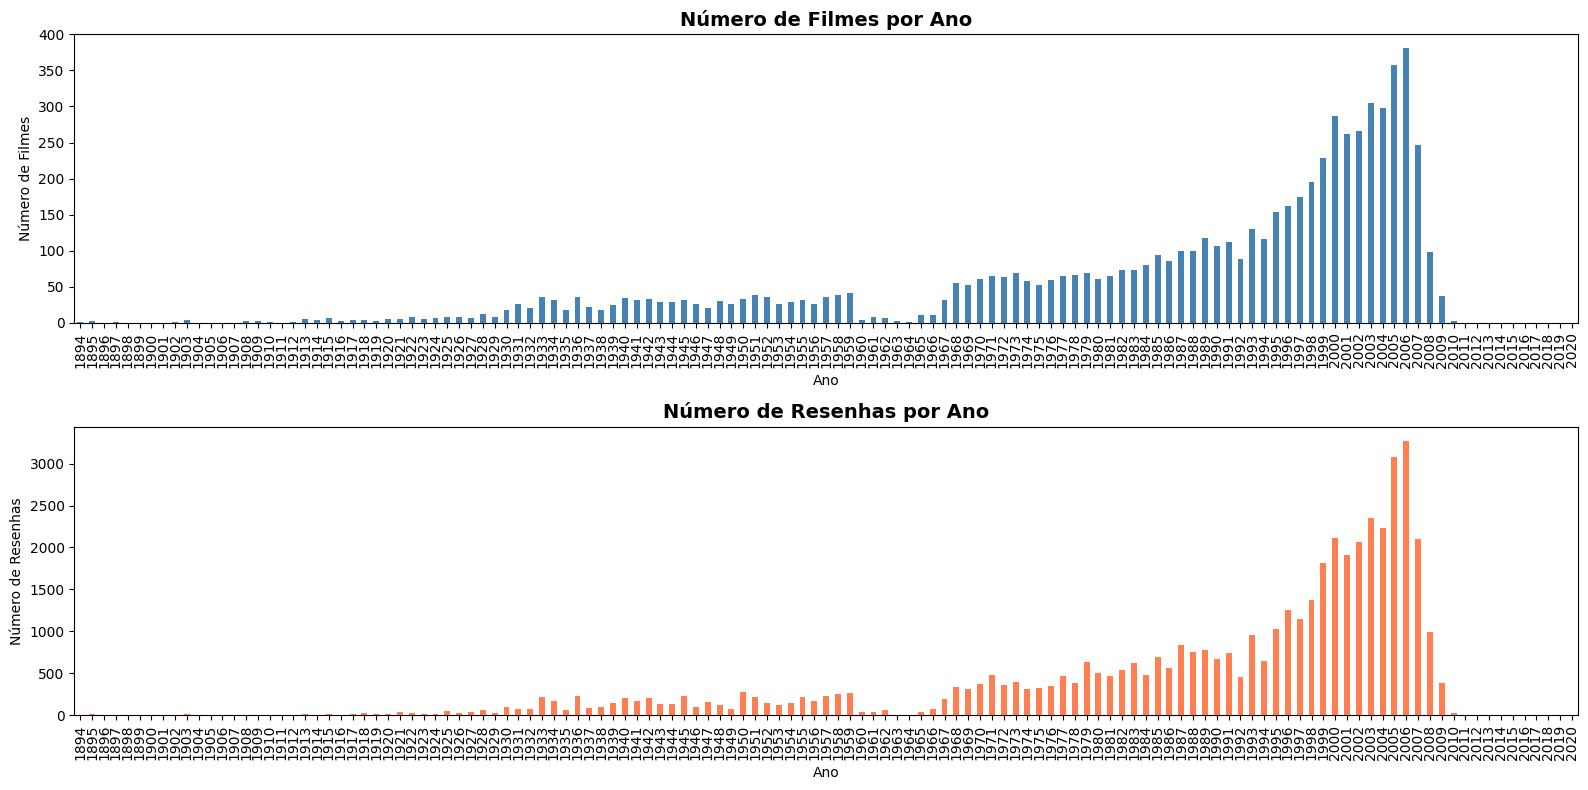

In [9]:
fig, axs = plt.subplots(2, 1, figsize=(16, 8))

# Número de filmes por ano
ax = axs[0]
dft1 = df_reviews[['tconst', 'start_year']].drop_duplicates() \
    ['start_year'].value_counts().sort_index()
dft1 = dft1.reindex(index=np.arange(dft1.index.min(), max(dft1.index.max(), 2021))).fillna(0)
dft1.plot(kind='bar', ax=ax, color='steelblue')
ax.set_title('Número de Filmes por Ano', fontsize=14, fontweight='bold')
ax.set_xlabel('Ano')
ax.set_ylabel('Número de Filmes')

# Número de resenhas por ano
ax = axs[1]
dft2 = df_reviews.groupby('start_year')['review'].count()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)
dft2.plot(kind='bar', ax=ax, color='coral')
ax.set_title('Número de Resenhas por Ano', fontsize=14, fontweight='bold')
ax.set_xlabel('Ano')
ax.set_ylabel('Número de Resenhas')

plt.tight_layout()
plt.show()

**Observação:** Verifica-se que o número de resenhas sofreu um grande aumento nos anos mais recentes, o que pode se dar pela disseminação do uso da internet e redes sociais. O acesso a essas ferramentas possibilitou a mais pessoas publicarem suas resenhas.

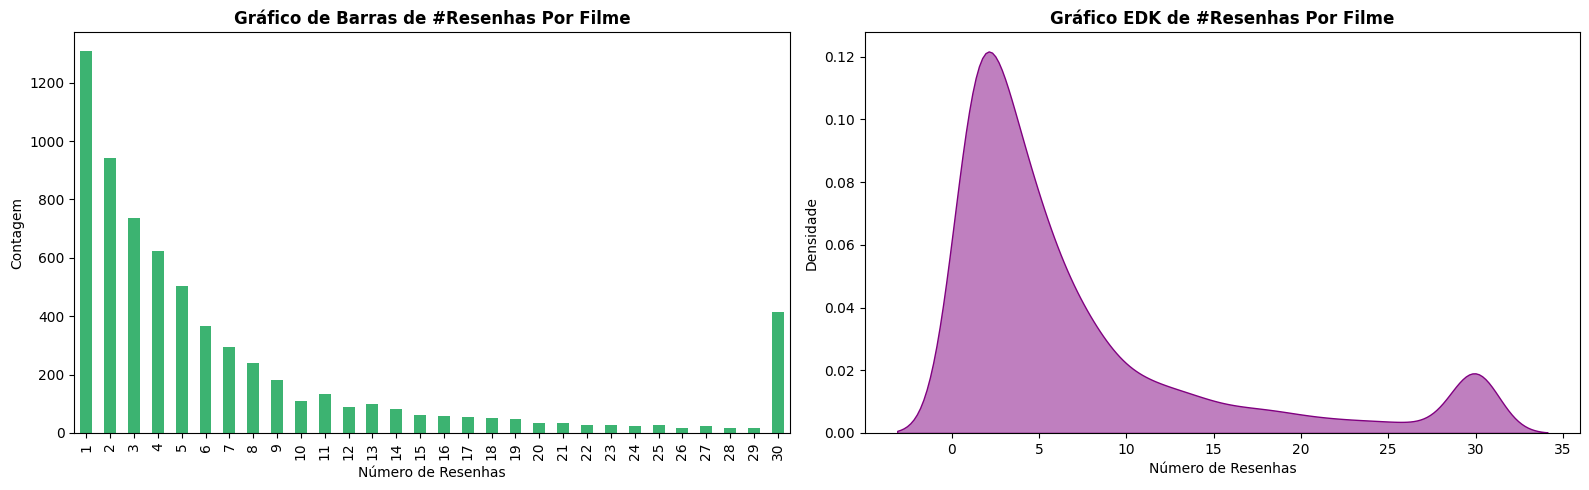

In [10]:
# Distribuição do número de resenhas por filme
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

# Gráfico de barras
ax = axs[0]
dft = df_reviews.groupby('tconst')['review'].count() \
    .value_counts() \
    .sort_index()
dft.plot.bar(ax=ax, color='mediumseagreen')
ax.set_title('Gráfico de Barras de #Resenhas Por Filme', fontsize=12, fontweight='bold')
ax.set_xlabel('Número de Resenhas')
ax.set_ylabel('Contagem')

# KDE
ax = axs[1]
dft = df_reviews.groupby('tconst')['review'].count()
sns.kdeplot(dft, ax=ax, color='purple', fill=True, alpha=0.5)
ax.set_title('Gráfico EDK de #Resenhas Por Filme', fontsize=12, fontweight='bold')
ax.set_xlabel('Número de Resenhas')
ax.set_ylabel('Densidade')

fig.tight_layout()
plt.show()

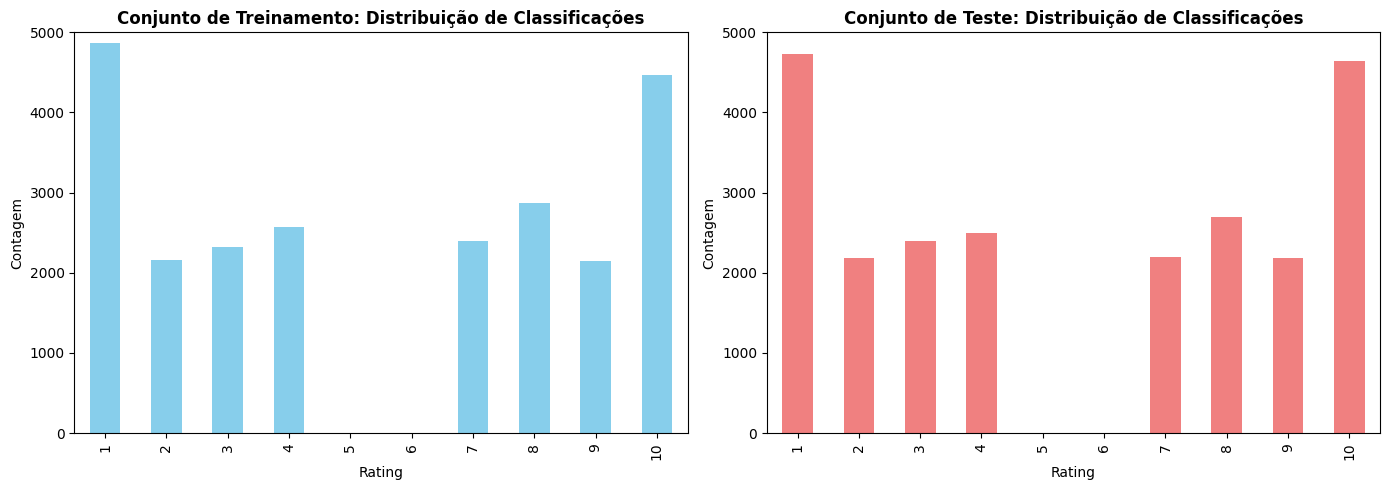

In [11]:
# Distribuição de ratings (treino e teste)
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

# Treino
ax = axs[0]
dft = df_reviews.query('ds_part == "train"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax, color='skyblue')
ax.set_ylim([0, 5000])
ax.set_title('Conjunto de Treinamento: Distribuição de Classificações', fontsize=12, fontweight='bold')
ax.set_xlabel('Rating')
ax.set_ylabel('Contagem')

# Teste
ax = axs[1]
dft = df_reviews.query('ds_part == "test"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax, color='lightcoral')
ax.set_ylim([0, 5000])
ax.set_title('Conjunto de Teste: Distribuição de Classificações', fontsize=12, fontweight='bold')
ax.set_xlabel('Rating')
ax.set_ylabel('Contagem')

fig.tight_layout()
plt.show()

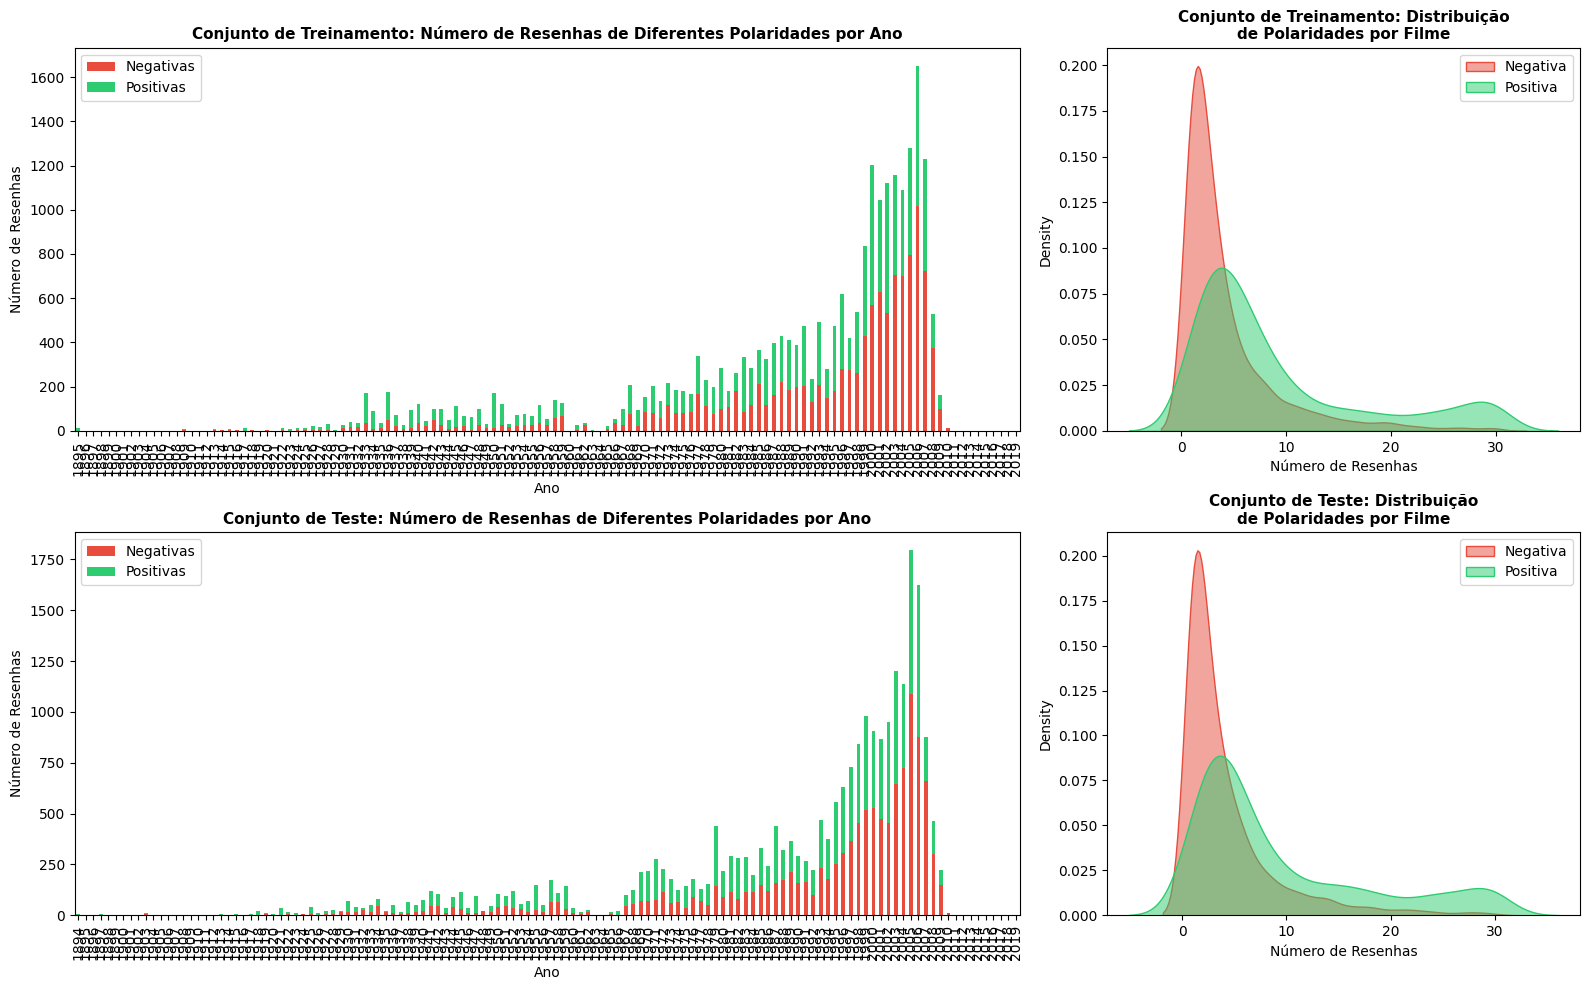

In [12]:
# Distribuição de polaridades ao longo dos anos
fig, axs = plt.subplots(2, 2, figsize=(16, 10),
                       gridspec_kw=dict(width_ratios=(2, 1), height_ratios=(1, 1)))

# Treino - Barras empilhadas
ax = axs[0][0]
dft = df_reviews.query('ds_part == "train"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax, color=['#e74c3c', '#2ecc71'])
ax.set_title('Conjunto de Treinamento: Número de Resenhas de Diferentes Polaridades por Ano',
            fontsize=11, fontweight='bold')
ax.set_xlabel('Ano')
ax.set_ylabel('Número de Resenhas')
ax.legend(['Negativas', 'Positivas'])

# Treino - KDE
ax = axs[0][1]
dft = df_reviews.query('ds_part == "train"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='#e74c3c', label='Negativa', fill=True, alpha=0.5, ax=ax)
sns.kdeplot(dft[1], color='#2ecc71', label='Positiva', fill=True, alpha=0.5, ax=ax)
ax.legend()
ax.set_title('Conjunto de Treinamento: Distribuição\nde Polaridades por Filme',
            fontsize=11, fontweight='bold')
ax.set_xlabel('Número de Resenhas')

# Teste - Barras empilhadas
ax = axs[1][0]
dft = df_reviews.query('ds_part == "test"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax, color=['#e74c3c', '#2ecc71'])
ax.set_title('Conjunto de Teste: Número de Resenhas de Diferentes Polaridades por Ano',
            fontsize=11, fontweight='bold')
ax.set_xlabel('Ano')
ax.set_ylabel('Número de Resenhas')
ax.legend(['Negativas', 'Positivas'])

# Teste - KDE
ax = axs[1][1]
dft = df_reviews.query('ds_part == "test"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='#e74c3c', label='Negativa', fill=True, alpha=0.5, ax=ax)
sns.kdeplot(dft[1], color='#2ecc71', label='Positiva', fill=True, alpha=0.5, ax=ax)
ax.legend()
ax.set_title('Conjunto de Teste: Distribuição\nde Polaridades por Filme',
            fontsize=11, fontweight='bold')
ax.set_xlabel('Número de Resenhas')

fig.tight_layout()
plt.show()

**Conclusão da EDA:** Os gráficos mostram que os conjuntos de treinamento e teste possuem uma distribuição parecida, mostrando a consistência dos dados. Não há desbalanceamento significativo entre classes positivas e negativas.

## 4. Normalização de Texto

In [13]:
def normalize_text_for_sentiment(text):

    # Conversão para minúsculas
    text = text.lower()

    # Remoção de URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)

    # Remoção de menções
    text = re.sub(r'@\w+', '', text)

    # Remoção de dígitos
    text = re.sub(r'\d+', '', text)

    # Remoção de caracteres especiais (mantém letras e apóstrofos)
    text = re.sub(r"[^a-zA-Z\']", ' ', text)

    # Tokenização
    tokens = word_tokenize(text)

    # Lematização
    lemmatizer = WordNetLemmatizer()

    # Stopwords
    stop_words = set(nltk_stopwords.words('english'))

    # Aplicar lematização e remover stopwords
    tokens = [lemmatizer.lemmatize(token) for token in tokens if token not in stop_words]

    # Juntar tokens
    normalized_text = ' '.join(tokens)

    return normalized_text

In [14]:
# Aplicar normalização a todas as resenhas
print("Aplicando normalização de texto...")
print("Isso pode levar cerca de 1-2 minutos para ~47k resenhas...")

df_reviews['review_norm'] = df_reviews['review'].apply(normalize_text_for_sentiment)

print("\nNormalização concluída!")
print(f"\nExemplo de resenha original:")
print(df_reviews['review'].iloc[0][:200])
print(f"\nResenha normalizada:")
print(df_reviews['review_norm'].iloc[0][:200])

Aplicando normalização de texto...
Isso pode levar cerca de 1-2 minutos para ~47k resenhas...

Normalização concluída!

Exemplo de resenha original:
The pakage implies that Warren Beatty and Goldie Hawn are pulling off a huge bank robbery, but that's not what I got out of it! I didn't get anything! In the first half there's a new character (withou

Resenha normalizada:
pakage implies warren beatty goldie hawn pulling huge bank robbery 's got n't get anything first half 's new character without introduction every scene first half hour completely incomprehensible rest


## 5. Divisão Treino/Teste

In [15]:
# Divisão treino/teste
# Felizmente, o dataset já está dividido em partes de treinamento/teste
df_reviews_train = df_reviews.query('ds_part == "train"').copy()
df_reviews_test = df_reviews.query('ds_part == "test"').copy()

# Targets
train_target = df_reviews_train['pos']
test_target = df_reviews_test['pos']

print(f"Conjunto de Treinamento: {df_reviews_train.shape[0]} resenhas")
print(f"Conjunto de Teste: {df_reviews_test.shape[0]} resenhas")
print(f"\nBalanceamento (Treino):")
print(train_target.value_counts())
print(f"\nBalanceamento (Teste):")
print(test_target.value_counts())

Conjunto de Treinamento: 23796 resenhas
Conjunto de Teste: 23533 resenhas

Balanceamento (Treino):
pos
0    11912
1    11884
Name: count, dtype: int64

Balanceamento (Teste):
pos
0    11803
1    11730
Name: count, dtype: int64


## 6. Função de Avaliação de Modelos

In [16]:
def evaluate_model(model, train_features, train_target, test_features, test_target):

    eval_stats = {}

    fig, axs = plt.subplots(1, 3, figsize=(20, 6))

    for data_type, features, target in (('train', train_features, train_target),
                                         ('test', test_features, test_target)):

        eval_stats[data_type] = {}

        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]

        # F1 Score
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [metrics.f1_score(target, pred_proba >= threshold) for threshold in f1_thresholds]

        # Armazenar o F1 Score máximo
        max_f1_score_idx = np.argmax(f1_scores)
        eval_stats[data_type]['F1 Score'] = f1_scores[max_f1_score_idx]

        # ROC Curve
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)
        eval_stats[data_type]['ROC AUC'] = roc_auc

        # Precision-Recall Curve
        precision, recall, pr_thresholds = metrics.precision_recall_curve(target, pred_proba)
        aps = metrics.average_precision_score(target, pred_proba)
        eval_stats[data_type]['APS'] = aps

        color = 'blue' if data_type == 'train' else 'green'

        # F1 Score Plot
        ax = axs[0]
        ax.plot(f1_thresholds, f1_scores, color=color,
               label=f'{data_type}, max F1={f1_scores[max_f1_score_idx]:.2f} @ threshold={f1_thresholds[max_f1_score_idx]:.2f}')
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds - threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx],
                   color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('Threshold')
        ax.set_ylabel('F1 Score')
        ax.legend(loc='lower center')
        ax.set_title('F1 Score vs Threshold')
        ax.grid(True, alpha=0.3)

        # ROC Curve Plot
        ax = axs[1]
        ax.plot(fpr, tpr, color=color, label=f'{data_type}, ROC AUC={roc_auc:.2f}')
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds - threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx],
                   color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('False Positive Rate')
        ax.set_ylabel('True Positive Rate')
        ax.legend(loc='lower center')
        ax.set_title('ROC Curve')
        ax.grid(True, alpha=0.3)

        # Precision-Recall Curve Plot
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{data_type}, AP={aps:.2f}')
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds - threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(recall[closest_value_idx], precision[closest_value_idx],
                   color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('Recall')
        ax.set_ylabel('Precision')
        ax.legend(loc='lower center')
        ax.set_title('Precision-Recall Curve')
        ax.grid(True, alpha=0.3)

        eval_stats[data_type]['Accuracy'] = metrics.accuracy_score(target, pred_target)

    df_eval_stats = pd.DataFrame(eval_stats).round(2)
    df_eval_stats = df_eval_stats.reindex(index=['Accuracy', 'F1 Score', 'APS', 'ROC AUC'])

    print(df_eval_stats)

    plt.tight_layout()
    plt.show()

    return df_eval_stats

## 7. Trabalhando com Modelos

### 7.0. Modelo 0 - DummyClassifier (Baseline)

In [17]:
# Vetorização TF-IDF para o baseline
print("Criando vetorização TF-IDF...")
tfidf_vectorizer = TfidfVectorizer(stop_words='english')
X_train_tfidf = tfidf_vectorizer.fit_transform(df_reviews_train['review_norm'])
X_test_tfidf = tfidf_vectorizer.transform(df_reviews_test['review_norm'])

print(f"Shape features treino: {X_train_tfidf.shape}")
print(f"Shape features teste: {X_test_tfidf.shape}")

Criando vetorização TF-IDF...
Shape features treino: (23796, 64070)
Shape features teste: (23533, 64070)


In [18]:
# Treinar DummyClassifier
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train_tfidf, train_target)
dummy_pred = dummy_clf.predict(X_test_tfidf)

print(f"Accuracy (Baseline): {accuracy_score(test_target, dummy_pred):.4f}")
print(f"F1 Score (Baseline): {f1_score(test_target, dummy_pred):.4f}")

Accuracy (Baseline): 0.5016
F1 Score (Baseline): 0.0000


AVALIAÇÃO MODELO 0 (BASELINE)
          train  test
Accuracy   0.50  0.50
F1 Score   0.67  0.67
APS        0.50  0.50
ROC AUC    0.50  0.50


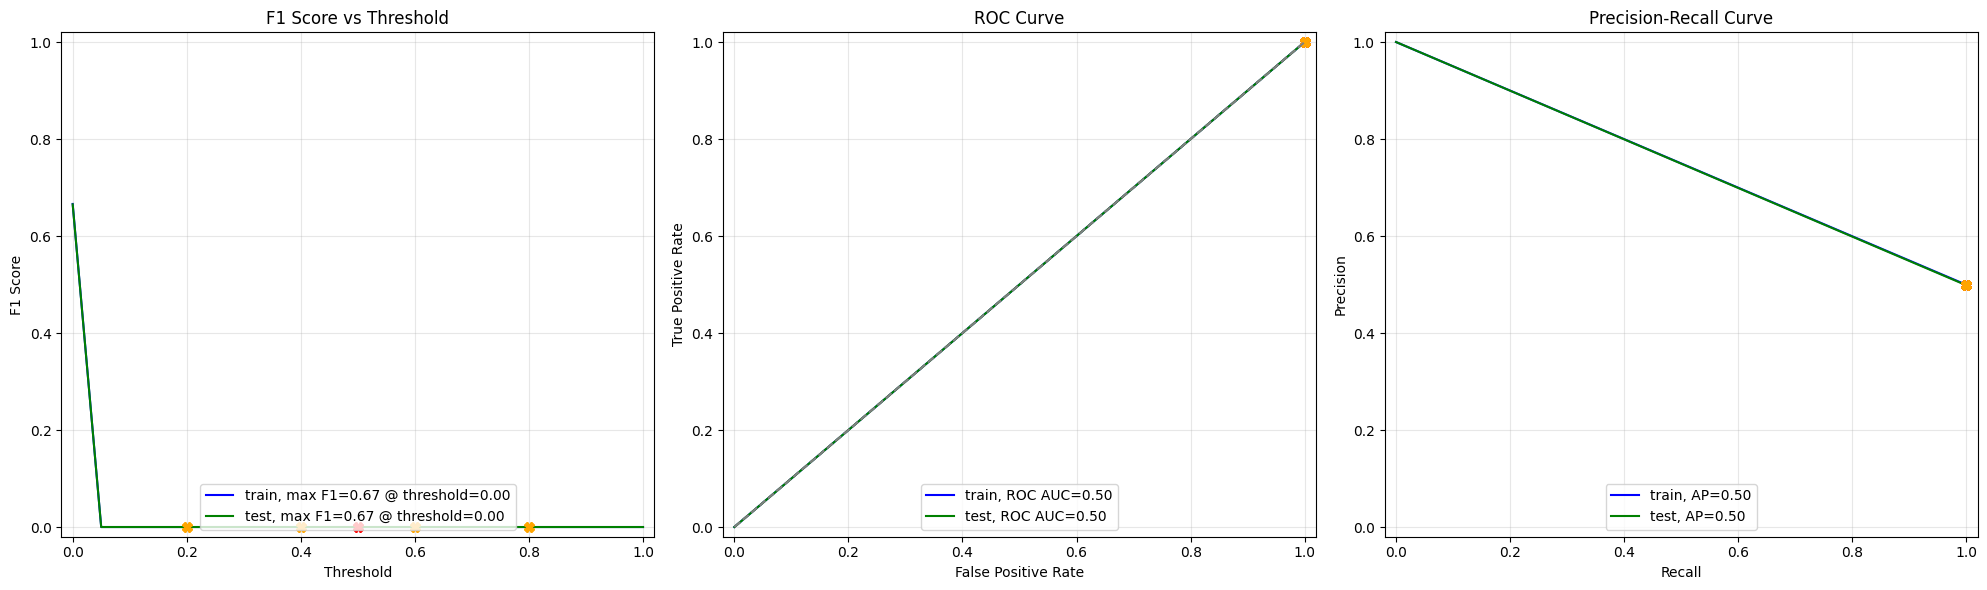

In [19]:
# Avaliar modelo baseline
print("AVALIAÇÃO MODELO 0 (BASELINE)")
results_model0 = evaluate_model(dummy_clf, X_train_tfidf, train_target, X_test_tfidf, test_target)

### 7.1. Modelo 1 - NLTK, TF-IDF e Regressão Logística


In [20]:
# Definir variáveis features_train e features_test
train_corpus = df_reviews_train['review_norm']
test_corpus = df_reviews_test['review_norm']
target_train = df_reviews_train['pos']

# Vetorização TF-IDF
count_tf_idf = TfidfVectorizer(stop_words='english')
features_train = count_tf_idf.fit_transform(train_corpus)
features_test = count_tf_idf.transform(test_corpus)

print(f"Features treino shape: {features_train.shape}")
print(f"Features teste shape: {features_test.shape}")

Features treino shape: (23796, 64070)
Features teste shape: (23533, 64070)


In [21]:
# Treinar Regressão Logística
lr = LogisticRegression(max_iter=2000, random_state=42)
lr.fit(features_train, target_train)
pred_test = lr.predict(features_test)

print(f"Accuracy (Modelo 1): {accuracy_score(test_target, pred_test):.4f}")
print(f"F1 Score (Modelo 1): {f1_score(test_target, pred_test):.4f}")

Accuracy (Modelo 1): 0.8754
F1 Score (Modelo 1): 0.8749



=== AVALIAÇÃO MODELO 1 ===
          train  test
Accuracy   0.93  0.88
F1 Score   0.93  0.88
APS        0.98  0.94
ROC AUC    0.98  0.95


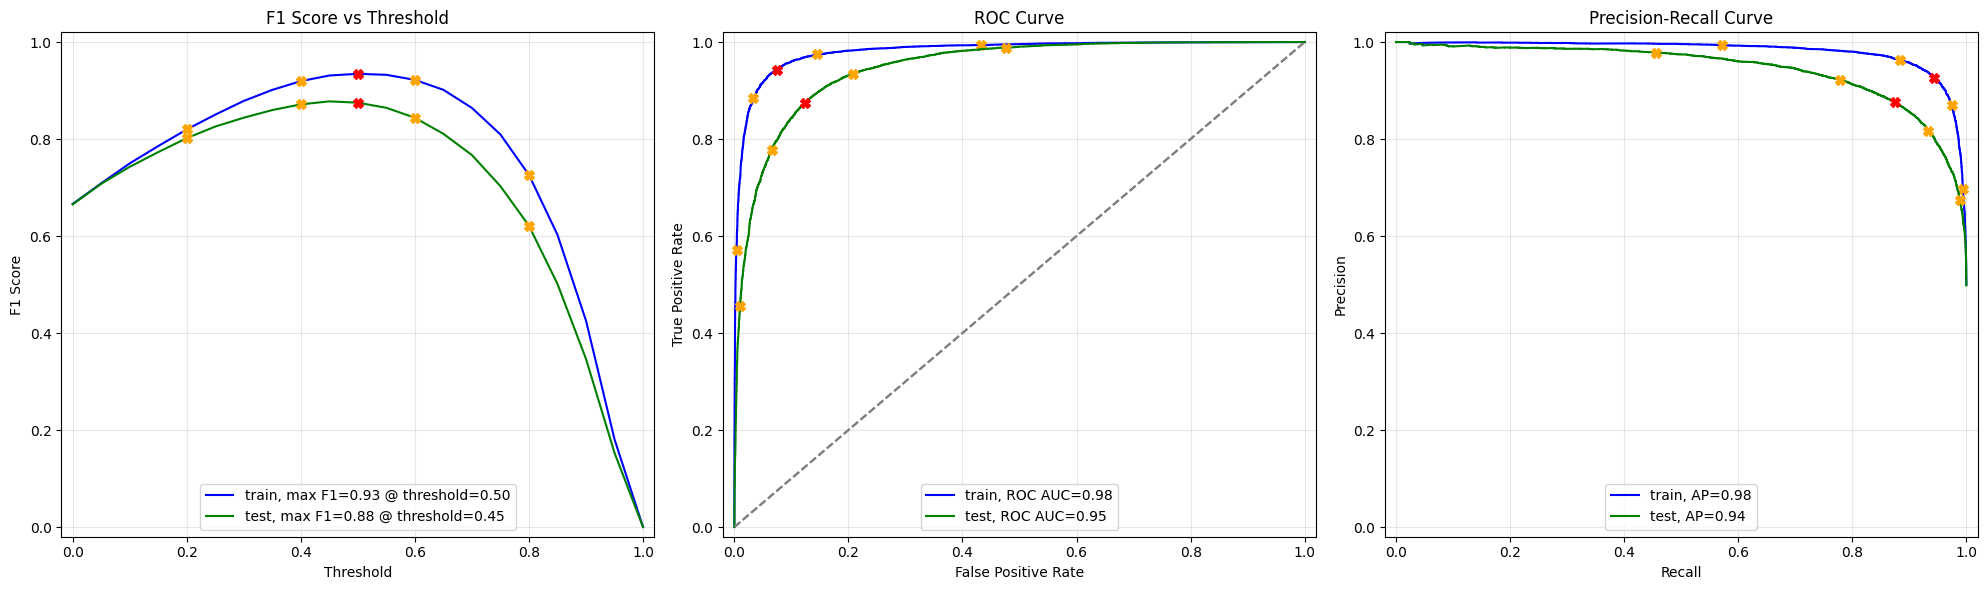

In [22]:
# Avaliar modelo
print("\n=== AVALIAÇÃO MODELO 1 ===")
results_model1 = evaluate_model(lr, features_train, target_train, features_test, test_target)

### 7.2. Modelo 2 - NLTK, Count Vectorizer (BoW) e Regressão Logística

Agora usa Count Vectorizer (Bag of Words) para diferenciar do Modelo 1.

In [23]:
# Vetorização com Count Vectorizer (Bag of Words)
count_vectorizer = CountVectorizer(stop_words='english')
features_train_bow = count_vectorizer.fit_transform(train_corpus)
features_test_bow = count_vectorizer.transform(test_corpus)

print(f"Features treino (BoW) shape: {features_train_bow.shape}")
print(f"Features teste (BoW) shape: {features_test_bow.shape}")

Features treino (BoW) shape: (23796, 64070)
Features teste (BoW) shape: (23533, 64070)


In [24]:
# Treinar Regressão Logística com BoW
log = LogisticRegression(max_iter=2000, random_state=42)
log.fit(features_train_bow, target_train)
pred_test_bow = log.predict(features_test_bow)

print(f"Accuracy (Modelo 2): {accuracy_score(test_target, pred_test_bow):.4f}")
print(f"F1 Score (Modelo 2): {f1_score(test_target, pred_test_bow):.4f}")

Accuracy (Modelo 2): 0.8519
F1 Score (Modelo 2): 0.8500



=== AVALIAÇÃO MODELO 2 ===
          train  test
Accuracy    1.0  0.85
F1 Score    1.0  0.85
APS         1.0  0.92
ROC AUC     1.0  0.92


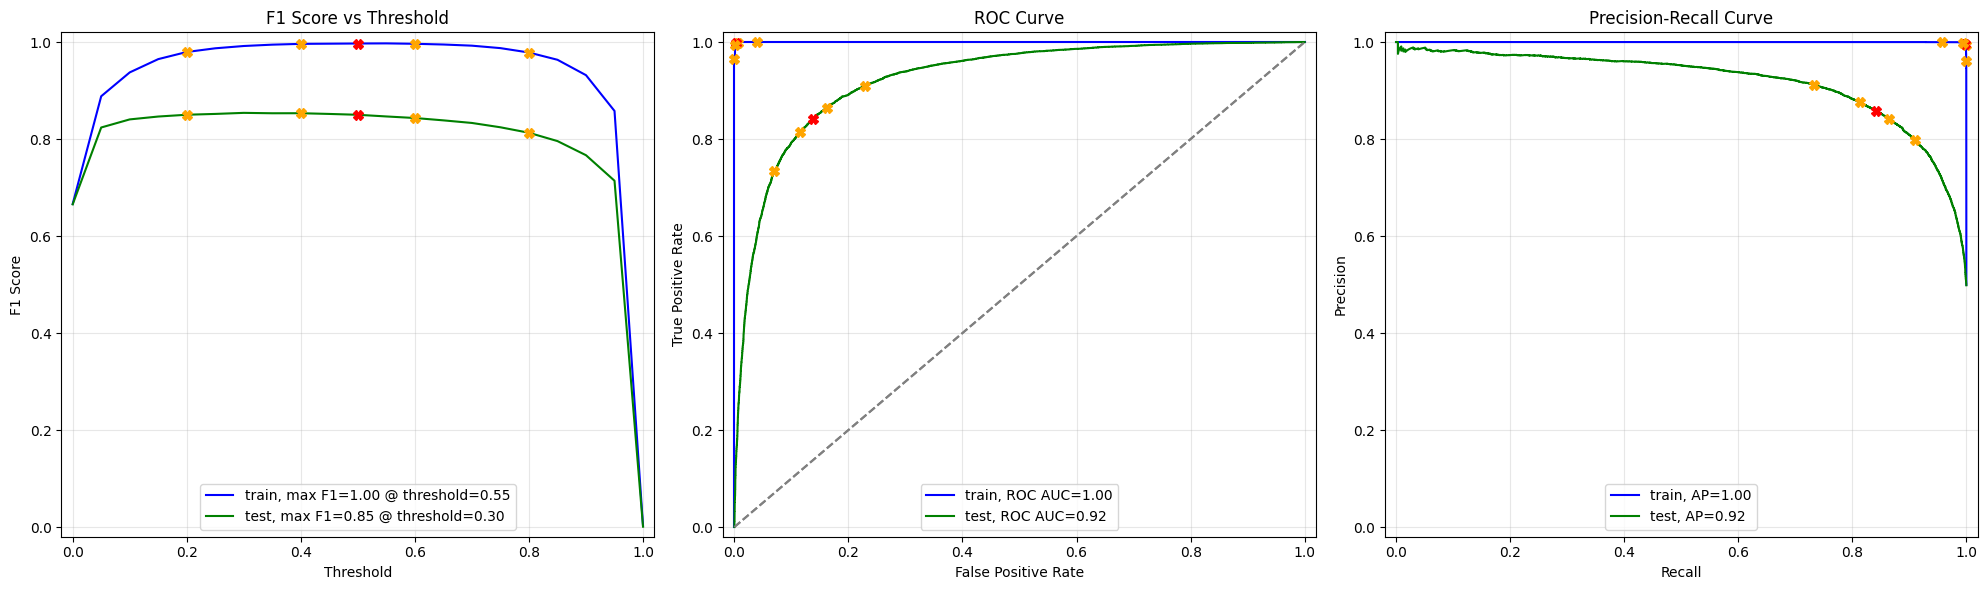

In [25]:
# Avaliar modelo 2
print("\n=== AVALIAÇÃO MODELO 2 ===")
results_model2 = evaluate_model(log, features_train_bow, target_train, features_test_bow, test_target)

### 7.3. Modelo 3 - spaCy, TF-IDF e Regressão Logística


In [26]:
# Carregar modelo spaCy

nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

In [27]:
def clear_text(text):

    clean_text = re.sub(r"[^a-zA-Z\']", ' ', text)
    clean_text = ' '.join(clean_text.split())
    return clean_text.lower()

def spacy_text_preprocessing(text):
    doc = nlp(text)
    tokens = [token.lemma_ for token in doc if not token.is_stop]
    return ' '.join(tokens)

In [28]:
print("Aplicando pré-processamento spaCy...")
df_reviews_m3 = df_reviews.copy()
df_reviews_m3['review_clean'] = df_reviews_m3['review'].apply(clear_text)
# Aplicar lematização com spaCy (pode levar alguns minutos)
df_reviews_m3['review_norm'] = df_reviews_m3['review_clean'].progress_apply(spacy_text_preprocessing)

Aplicando pré-processamento spaCy...


100%|██████████| 47329/47329 [11:23<00:00, 69.27it/s]


In [29]:
# Divisão treino/teste
df_reviews_m3_train = df_reviews_m3.query('ds_part == "train"').copy()
df_reviews_m3_test = df_reviews_m3.query('ds_part == "test"').copy()

train_corpus3 = df_reviews_m3_train['review_norm']
test_corpus3 = df_reviews_m3_test['review_norm']
target_train3 = df_reviews_m3_train['pos']

# Vetorização TF-IDF
stop_words = list(nltk_stopwords.words('english'))
count_tf_idf_3 = TfidfVectorizer(stop_words=stop_words)
features_train3 = count_tf_idf_3.fit_transform(train_corpus3)
features_test3 = count_tf_idf_3.transform(test_corpus3)

print(f"Features treino (spaCy) shape: {features_train3.shape}")
print(f"Features teste (spaCy) shape: {features_test3.shape}")

Features treino (spaCy) shape: (23796, 58982)
Features teste (spaCy) shape: (23533, 58982)


In [30]:
# Treinar Regressão Logística
lr_3 = LogisticRegression(max_iter=2000, random_state=42)
lr_3.fit(features_train3, target_train3)
pred_test_3 = lr_3.predict(features_test3)

print(f"Accuracy (Modelo 3): {accuracy_score(test_target, pred_test_3):.4f}")
print(f"F1 Score (Modelo 3): {f1_score(test_target, pred_test_3):.4f}")

Accuracy (Modelo 3): 0.8745
F1 Score (Modelo 3): 0.8744



=== AVALIAÇÃO MODELO 3 ===
          train  test
Accuracy   0.93  0.87
F1 Score   0.93  0.87
APS        0.98  0.94
ROC AUC    0.98  0.95


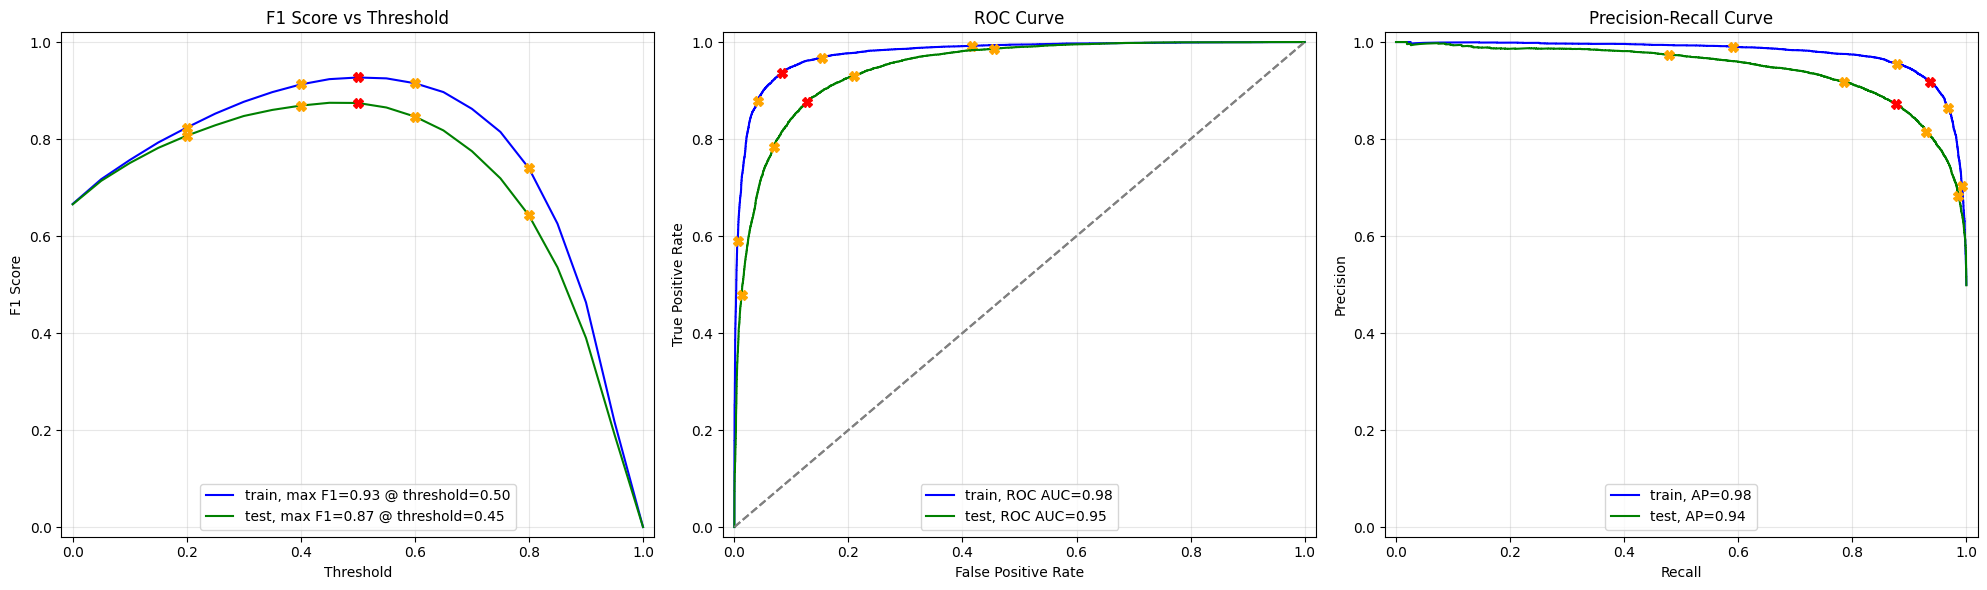

In [31]:
print("\n=== AVALIAÇÃO MODELO 3 ===")
results_model3 = evaluate_model(lr_3, features_train3, target_train3, features_test3, test_target)

### 7.4. Modelo 4 - spaCy, TF-IDF e LGBMClassifier

In [32]:
# Treinar LGBMClassifier com features do spaCy
lgbm_3 = LGBMClassifier(random_state=42, verbose=-1)
lgbm_3.fit(features_train3, target_train3)
pred_test_4 = lgbm_3.predict(features_test3)

print(f"Accuracy (Modelo 4): {accuracy_score(test_target, pred_test_4):.4f}")
print(f"F1 Score (Modelo 4): {f1_score(test_target, pred_test_4):.4f}")

Accuracy (Modelo 4): 0.8528
F1 Score (Modelo 4): 0.8539



=== AVALIAÇÃO MODELO 4 ===
          train  test
Accuracy   0.91  0.85
F1 Score   0.91  0.86
APS        0.97  0.93
ROC AUC    0.97  0.93


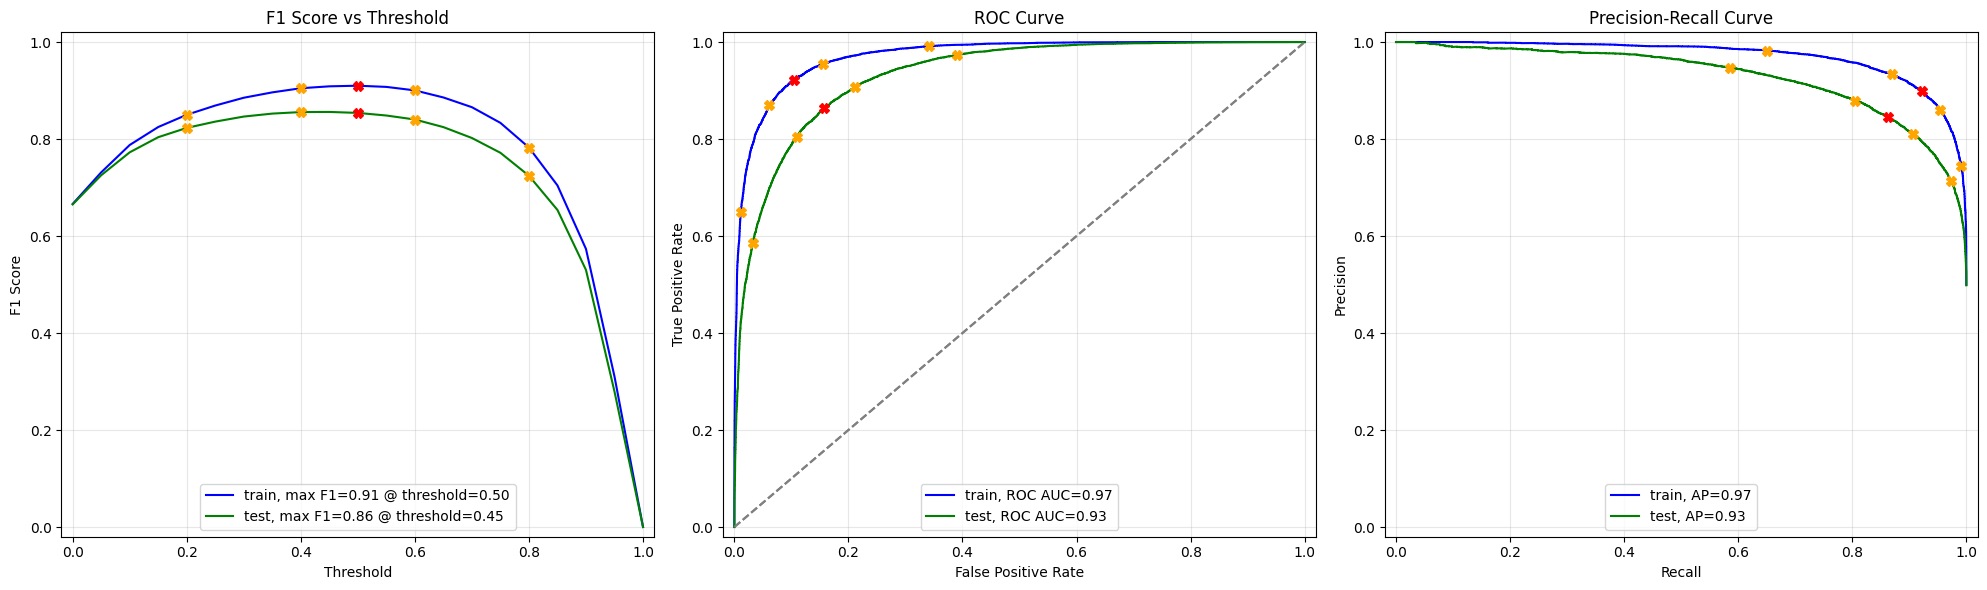

In [33]:
# Avaliar modelo 4
print("\n=== AVALIAÇÃO MODELO 4 ===")
results_model4 = evaluate_model(lgbm_3, features_train3, target_train3, features_test3, test_target)

### 7.5. Modelo 5 - NLTK, TF-IDF e LGBMClassifier

In [34]:
# Treinar LGBMClassifier com features do NLTK (Modelo 1)
lgbm = LGBMClassifier(random_state=42, verbose=-1)
lgbm.fit(features_train, target_train)
pred_test_5 = lgbm.predict(features_test)

print(f"Accuracy (Modelo 5): {accuracy_score(test_target, pred_test_5):.4f}")
print(f"F1 Score (Modelo 5): {f1_score(test_target, pred_test_5):.4f}")

Accuracy (Modelo 5): 0.8545
F1 Score (Modelo 5): 0.8560



=== AVALIAÇÃO MODELO 5 ===
          train  test
Accuracy   0.91  0.85
F1 Score   0.91  0.86
APS        0.97  0.93
ROC AUC    0.97  0.93


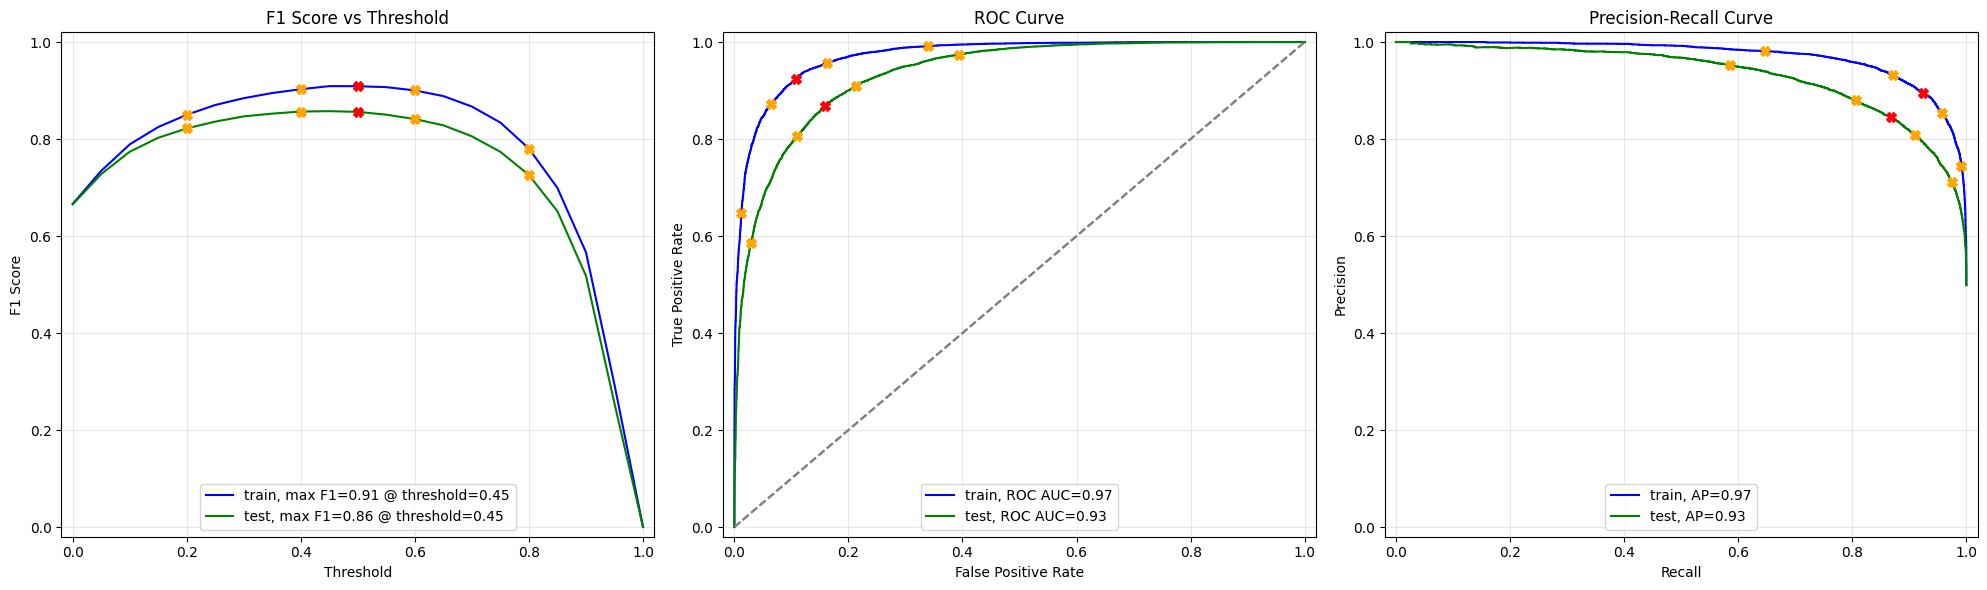

In [35]:
# Avaliar modelo 5
print("\n=== AVALIAÇÃO MODELO 5 ===")
results_model5 = evaluate_model(lgbm, features_train, train_target, features_test, test_target)

### 7.6. Modelo 6 - BERT

**Nota:** BERT completo pode levar várias horas. Aqui usamos uma amostra de 5000 exemplos para demonstração.

In [36]:
def BERT_text_to_embeddings(texts, max_length=128, batch_size=32, force_device=None, disable_progress_bar=False):

    tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased')
    config = transformers.BertConfig.from_pretrained('bert-base-uncased')
    model = transformers.BertModel.from_pretrained('bert-base-uncased')

    ids_list = []
    attention_mask_list = []

    # Texto para IDs de tokens com máscaras de atenção
    for input_text in tqdm(texts, disable=disable_progress_bar, desc="Tokenizando"):
        ids = tokenizer.encode(input_text.lower(), add_special_tokens=True,
                             truncation=True, max_length=max_length)
        padded = np.array(ids + [0]*(max_length - len(ids)))
        attention_mask = np.where(padded != 0, 1, 0)
        ids_list.append(padded)
        attention_mask_list.append(attention_mask)

    # Configurar dispositivo
    if force_device is not None:
        device = torch.device(force_device)
    else:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    model.to(device)
    if not disable_progress_bar:
        print(f'Usando o dispositivo: {device}')

    embeddings = []

    # Processar em batches
    for i in tqdm(range(math.ceil(len(ids_list)/batch_size)),
                 disable=disable_progress_bar, desc="Gerando embeddings"):
        ids_batch = torch.LongTensor(ids_list[batch_size*i:batch_size*(i+1)]).to(device)
        attention_mask_batch = torch.LongTensor(attention_mask_list[batch_size*i:batch_size*(i+1)]).to(device)

        with torch.no_grad():
            model.eval()
            batch_embeddings = model(input_ids=ids_batch, attention_mask=attention_mask_batch)
        embeddings.append(batch_embeddings[0][:,0,:].detach().cpu().numpy())

    return np.concatenate(embeddings)

In [37]:
sample_size = 5000 # Defina o tamanho da amostra para os embeddings BERT

# Criar amostras estratificadas para garantir a presença de ambas as classes
# Dividimos o sample_size igualmente entre as duas classes (0 e 1)
df_train_sample_neg = df_reviews_train[df_reviews_train['pos'] == 0].sample(n=sample_size // 2, random_state=42)
df_train_sample_pos = df_reviews_train[df_reviews_train['pos'] == 1].sample(n=sample_size // 2, random_state=42)
df_train_sample = pd.concat([df_train_sample_neg, df_train_sample_pos]).sample(frac=1, random_state=42).reset_index(drop=True)

df_test_sample_neg = df_reviews_test[df_reviews_test['pos'] == 0].sample(n=sample_size // 2, random_state=42)
df_test_sample_pos = df_reviews_test[df_reviews_test['pos'] == 1].sample(n=sample_size // 2, random_state=42)
df_test_sample = pd.concat([df_test_sample_neg, df_test_sample_pos]).sample(frac=1, random_state=42).reset_index(drop=True)

print(f"Treino: {len(df_train_sample)} exemplos")
print(f"Teste: {len(df_test_sample)} exemplos")
print(f"\nBalanceamento da amostra de Treino:\n{df_train_sample['pos'].value_counts()}")
print(f"\nBalanceamento da amostra de Teste:\n{df_test_sample['pos'].value_counts()}")

# Gerar embeddings BERT
print("\nGerando embeddings BERT...")
train_features_6 = BERT_text_to_embeddings(
    df_train_sample['review_norm'],
    max_length=128,
    batch_size=32,
    force_device='cuda'  # Alterado para 'cuda' para aproveitar a GPU (A100)
)

test_features_6 = BERT_text_to_embeddings(
    df_test_sample['review_norm'],
    max_length=128,
    batch_size=32,
    force_device='cuda' # Alterado para 'cuda' para aproveitar a GPU (A100)
)

train_target_6 = df_train_sample['pos']
test_target_6 = df_test_sample['pos']

print(f"Shape embeddings treino: {train_features_6.shape}")
print(f"Shape embeddings teste: {test_features_6.shape}")

Treino: 5000 exemplos
Teste: 5000 exemplos

Balanceamento da amostra de Treino:
pos
0    2500
1    2500
Name: count, dtype: int64

Balanceamento da amostra de Teste:
pos
0    2500
1    2500
Name: count, dtype: int64

Gerando embeddings BERT...


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Tokenizando: 100%|██████████| 5000/5000 [00:12<00:00, 402.32it/s]


Usando o dispositivo: cuda


Tokenizando: 100%|██████████| 5000/5000 [00:12<00:00, 401.31it/s]


Usando o dispositivo: cuda


Gerando embeddings: 100%|██████████| 157/157 [00:07<00:00, 20.44it/s]

Shape embeddings treino: (5000, 768)
Shape embeddings teste: (5000, 768)


In [38]:
# Opcional: Salvar embeddings para reutilização
# np.savez_compressed('features_bert_sample.npz',
#                     train_features_6=train_features_6,
#                     test_features_6=test_features_6)
# print("Embeddings salvos em 'features_bert_sample.npz'")

In [39]:
# Treinar classificador com embeddings BERT
clf_bert = LogisticRegression(max_iter=2000, random_state=42)
clf_bert.fit(train_features_6, train_target_6)
pred_test_6 = clf_bert.predict(test_features_6)

print(f"Accuracy (Modelo 6 - BERT): {accuracy_score(test_target_6, pred_test_6):.4f}")
print(f"F1 Score (Modelo 6 - BERT): {f1_score(test_target_6, pred_test_6):.4f}")

Accuracy (Modelo 6 - BERT): 0.7834
F1 Score (Modelo 6 - BERT): 0.7811



=== AVALIAÇÃO MODELO 6 (BERT) ===
          train  test
Accuracy   0.84  0.78
F1 Score   0.85  0.79
APS        0.93  0.86
ROC AUC    0.92  0.87


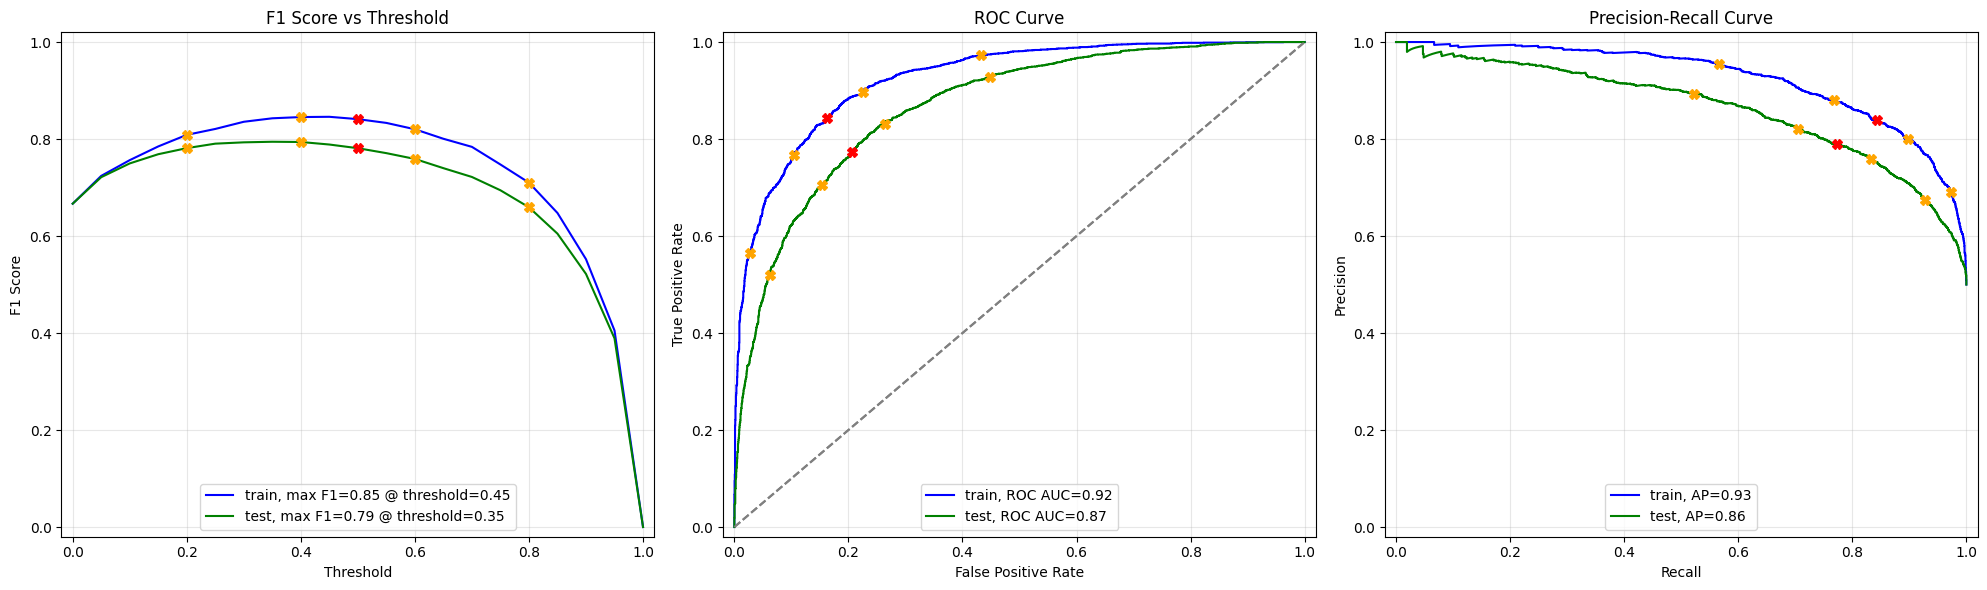

In [40]:
# Avaliar modelo BERT
print("\n=== AVALIAÇÃO MODELO 6 (BERT) ===")
results_model6 = evaluate_model(clf_bert, train_features_6, train_target_6,
                                test_features_6, test_target_6)

## 8. Comparação de Modelos

**ADICIONADO:** Tabela comparativa completa de todos os modelos treinados.

In [41]:
# Coletar todas as métricas dos modelos
print("📊 TABELA COMPARATIVA DE MODELOS\n")

# Criar dataframe com resultados
comparison_data = {
    'Modelo': [
        'Modelo 0: DummyClassifier (Baseline)',
        'Modelo 1: NLTK + TF-IDF + LogReg',
        'Modelo 2: NLTK + BoW + LogReg',
        'Modelo 3: spaCy + TF-IDF + LogReg',
        'Modelo 4: spaCy + TF-IDF + LightGBM',
        'Modelo 5: NLTK + TF-IDF + LightGBM',
        'Modelo 6: BERT + LogReg (sample)'
    ],
    'Accuracy_Train': [
        results_model0['train']['Accuracy'],
        results_model1['train']['Accuracy'],
        results_model2['train']['Accuracy'],
        results_model3['train']['Accuracy'],
        results_model4['train']['Accuracy'],
        results_model5['train']['Accuracy'],
        results_model6['train']['Accuracy']
    ],
    'Accuracy_Test': [
        results_model0['test']['Accuracy'],
        results_model1['test']['Accuracy'],
        results_model2['test']['Accuracy'],
        results_model3['test']['Accuracy'],
        results_model4['test']['Accuracy'],
        results_model5['test']['Accuracy'],
        results_model6['test']['Accuracy']
    ],
    'F1_Train': [
        results_model0['train']['F1 Score'],
        results_model1['train']['F1 Score'],
        results_model2['train']['F1 Score'],
        results_model3['train']['F1 Score'],
        results_model4['train']['F1 Score'],
        results_model5['train']['F1 Score'],
        results_model6['train']['F1 Score']
    ],
    'F1_Test': [
        results_model0['test']['F1 Score'],
        results_model1['test']['F1 Score'],
        results_model2['test']['F1 Score'],
        results_model3['test']['F1 Score'],
        results_model4['test']['F1 Score'],
        results_model5['test']['F1 Score'],
        results_model6['test']['F1 Score']
    ],
    'ROC_AUC_Test': [
        results_model0['test']['ROC AUC'],
        results_model1['test']['ROC AUC'],
        results_model2['test']['ROC AUC'],
        results_model3['test']['ROC AUC'],
        results_model4['test']['ROC AUC'],
        results_model5['test']['ROC AUC'],
        results_model6['test']['ROC AUC']
    ]
}

df_comparison = pd.DataFrame(comparison_data)

# Destacar se atingiu a meta F1 >= 0.85
df_comparison['Atingiu Meta (F1≥0.85)'] = df_comparison['F1_Test'].apply(
    lambda x: '✅ SIM' if x >= 0.85 else '❌ NÃO'
)

# Mostrar tabela
print(df_comparison.to_string(index=False))

# Salvar para uso posterior
df_comparison.to_csv('comparacao_modelos.csv', index=False)
print("\n💾 Tabela salva em 'comparacao_modelos.csv'")

📊 TABELA COMPARATIVA DE MODELOS

                              Modelo  Accuracy_Train  Accuracy_Test  F1_Train  F1_Test  ROC_AUC_Test Atingiu Meta (F1≥0.85)
Modelo 0: DummyClassifier (Baseline)            0.50           0.50      0.67     0.67          0.50                  ❌ NÃO
    Modelo 1: NLTK + TF-IDF + LogReg            0.93           0.88      0.93     0.88          0.95                  ✅ SIM
       Modelo 2: NLTK + BoW + LogReg            1.00           0.85      1.00     0.85          0.92                  ✅ SIM
   Modelo 3: spaCy + TF-IDF + LogReg            0.93           0.87      0.93     0.87          0.95                  ✅ SIM
 Modelo 4: spaCy + TF-IDF + LightGBM            0.91           0.85      0.91     0.86          0.93                  ✅ SIM
  Modelo 5: NLTK + TF-IDF + LightGBM            0.91           0.85      0.91     0.86          0.93                  ✅ SIM
    Modelo 6: BERT + LogReg (sample)            0.84           0.78      0.85     0.79          0.8

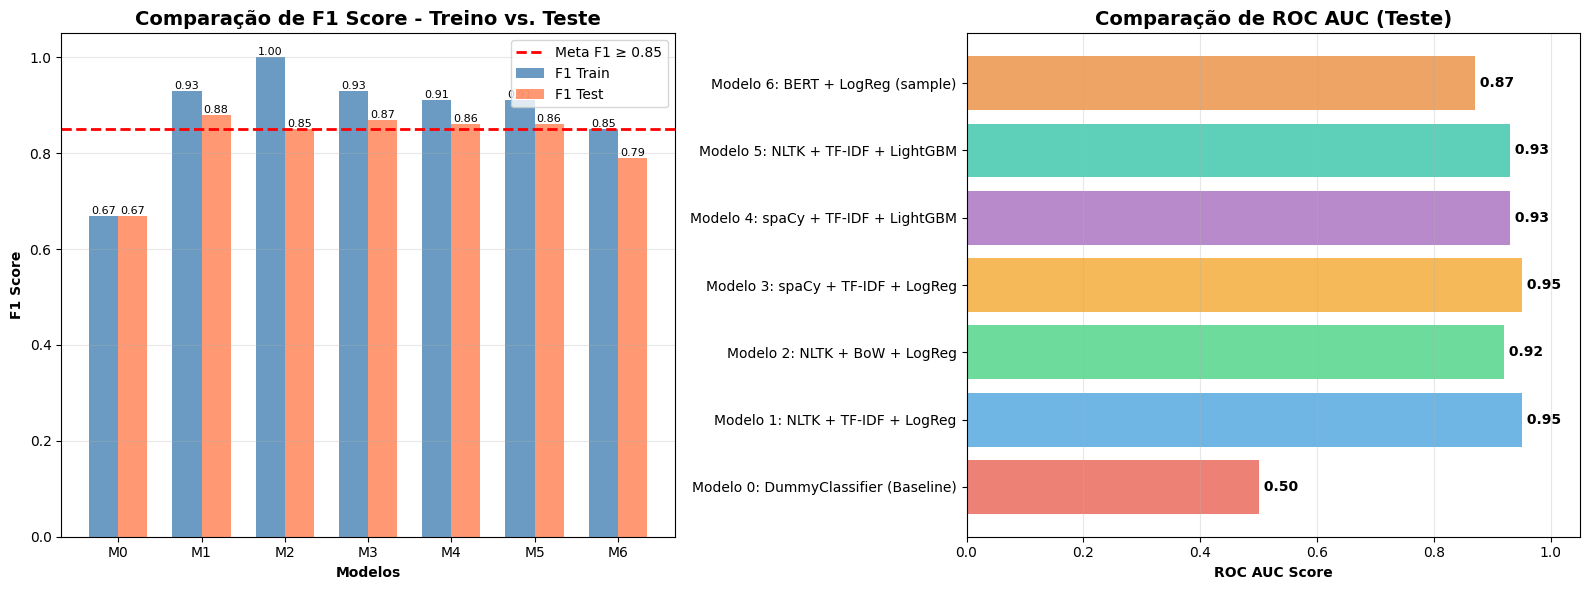

In [42]:
# Visualização comparativa
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# F1 Score comparison
ax = axes[0]
x = np.arange(len(df_comparison))
width = 0.35

bars1 = ax.bar(x - width/2, df_comparison['F1_Train'], width, label='F1 Train', alpha=0.8, color='steelblue')
bars2 = ax.bar(x + width/2, df_comparison['F1_Test'], width, label='F1 Test', alpha=0.8, color='coral')

# Linha de meta F1 >= 0.85
ax.axhline(y=0.85, color='red', linestyle='--', linewidth=2, label='Meta F1 ≥ 0.85')

ax.set_xlabel('Modelos', fontweight='bold')
ax.set_ylabel('F1 Score', fontweight='bold')
ax.set_title('Comparação de F1 Score - Treino vs. Teste', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels([f'M{i}' for i in range(7)], rotation=0)
ax.legend()
ax.grid(axis='y', alpha=0.3)
ax.set_ylim([0, 1.05])

# Adicionar valores nas barras
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
               f'{height:.2f}', ha='center', va='bottom', fontsize=8)

# ROC AUC comparison
ax = axes[1]
colors = ['#e74c3c', '#3498db', '#2ecc71', '#f39c12', '#9b59b6', '#1abc9c', '#e67e22']
bars = ax.barh(df_comparison['Modelo'], df_comparison['ROC_AUC_Test'], color=colors, alpha=0.7)

ax.set_xlabel('ROC AUC Score', fontweight='bold')
ax.set_title('Comparação de ROC AUC (Teste)', fontsize=14, fontweight='bold')
ax.set_xlim([0, 1.05])
ax.grid(axis='x', alpha=0.3)

# Adicionar valores
for i, bar in enumerate(bars):
    width = bar.get_width()
    ax.text(width, bar.get_y() + bar.get_height()/2.,
           f' {width:.2f}', ha='left', va='center', fontweight='bold')

plt.tight_layout()
plt.savefig('comparacao_modelos.png', dpi=300, bbox_inches='tight')
plt.show()


## 9. Teste com Resenhas Customizadas


In [43]:
# Criar resenhas de teste customizadas
my_reviews = pd.DataFrame([
    "A heartwarming tale that hits all the right emotional notes without feeling forced.",
    "This film is a visual masterpiece, but the plot left much to be desired.",
    "A laugh-out-loud comedy that's perfect for a weekend escape.",
    "While the action scenes are thrilling, the storyline feels a bit too predictable.",
    "An intense thriller that will keep you on the edge of your seat until the very end.",
    "Great performances, but the pacing made it drag in parts.",
    "A gripping story of survival, but the emotional depth wasn't fully explored.",
    "The chemistry between the leads makes this rom-com a joy to watch.",
    "Visually stunning, but the lack of character development holds it back.",
    "An ambitious film that delivers on style but falters in substance."
], columns=['review'])

# Aplicar mesma normalização
my_reviews['review_norm'] = my_reviews['review'].apply(normalize_text_for_sentiment)

print("Resenhas customizadas criadas e normalizadas")
my_reviews

Resenhas customizadas criadas e normalizadas


,review,review_norm
0,A heartwarming tale that hits all the right em...,heartwarming tale hit right emotional note wit...
1,"This film is a visual masterpiece, but the plo...",film visual masterpiece plot left much desired
2,A laugh-out-loud comedy that's perfect for a w...,laugh loud comedy 's perfect weekend escape
3,"While the action scenes are thrilling, the sto...",action scene thrilling storyline feel bit pred...
4,An intense thriller that will keep you on the ...,intense thriller keep edge seat end
5,"Great performances, but the pacing made it dra...",great performance pacing made drag part
6,"A gripping story of survival, but the emotiona...",gripping story survival emotional depth n't fu...
7,The chemistry between the leads makes this rom...,chemistry lead make rom com joy watch
8,"Visually stunning, but the lack of character d...",visually stunning lack character development h...
9,An ambitious film that delivers on style but f...,ambitious film delivers style falter substance


### 9.1. Teste com Modelo 1 (NLTK + TF-IDF + LogReg)

In [44]:
# USAR modelo já treinado (NÃO re-treinar!)
my_features_m1 = count_tf_idf.transform(my_reviews['review_norm'])
my_reviews['pred_proba_m1'] = lr.predict_proba(my_features_m1)[:, 1]
my_reviews['pred_label_m1'] = lr.predict(my_features_m1)

print("=== RESULTADOS - MODELO 1 (NLTK + TF-IDF + LogReg) ===")
for i, row in my_reviews.iterrows():
    sentiment = "😊 POSITIVA" if row['pred_label_m1'] == 1 else "😞 NEGATIVA"
    print(f"{row['pred_proba_m1']:.2f} | {sentiment} | {row['review'][:70]}...")

=== RESULTADOS - MODELO 1 (NLTK + TF-IDF + LogReg) ===
0.84 | 😊 POSITIVA | A heartwarming tale that hits all the right emotional notes without fe...
0.50 | 😞 NEGATIVA | This film is a visual masterpiece, but the plot left much to be desire...
0.79 | 😊 POSITIVA | A laugh-out-loud comedy that's perfect for a weekend escape....
0.47 | 😞 NEGATIVA | While the action scenes are thrilling, the storyline feels a bit too p...
0.93 | 😊 POSITIVA | An intense thriller that will keep you on the edge of your seat until ...
0.90 | 😊 POSITIVA | Great performances, but the pacing made it drag in parts....
0.78 | 😊 POSITIVA | A gripping story of survival, but the emotional depth wasn't fully exp...
0.60 | 😊 POSITIVA | The chemistry between the leads makes this rom-com a joy to watch....
0.22 | 😞 NEGATIVA | Visually stunning, but the lack of character development holds it back...
0.51 | 😊 POSITIVA | An ambitious film that delivers on style but falters in substance....


### 9.2. Teste com Modelo 2 (NLTK + BoW + LogReg)

In [45]:
# Usar modelo 2 já treinado
my_features_m2 = count_vectorizer.transform(my_reviews['review_norm'])
my_reviews['pred_proba_m2'] = log.predict_proba(my_features_m2)[:, 1]
my_reviews['pred_label_m2'] = log.predict(my_features_m2)

print("=== RESULTADOS - MODELO 2 (NLTK + BoW + LogReg) ===")
for i, row in my_reviews.iterrows():
    sentiment = "😊 POSITIVA" if row['pred_label_m2'] == 1 else "😞 NEGATIVA"
    print(f"{row['pred_proba_m2']:.2f} | {sentiment} | {row['review'][:70]}...")

=== RESULTADOS - MODELO 2 (NLTK + BoW + LogReg) ===
0.81 | 😊 POSITIVA | A heartwarming tale that hits all the right emotional notes without fe...
0.59 | 😊 POSITIVA | This film is a visual masterpiece, but the plot left much to be desire...
0.62 | 😊 POSITIVA | A laugh-out-loud comedy that's perfect for a weekend escape....
0.43 | 😞 NEGATIVA | While the action scenes are thrilling, the storyline feels a bit too p...
0.87 | 😊 POSITIVA | An intense thriller that will keep you on the edge of your seat until ...
0.55 | 😊 POSITIVA | Great performances, but the pacing made it drag in parts....
0.81 | 😊 POSITIVA | A gripping story of survival, but the emotional depth wasn't fully exp...
0.70 | 😊 POSITIVA | The chemistry between the leads makes this rom-com a joy to watch....
0.22 | 😞 NEGATIVA | Visually stunning, but the lack of character development holds it back...
0.50 | 😊 POSITIVA | An ambitious film that delivers on style but falters in substance....


### 9.3. Teste com Modelo 5 (NLTK + TF-IDF + LightGBM)

In [46]:
# Usar modelo 5 já treinado
my_features_m5 = count_tf_idf.transform(my_reviews['review_norm'])
my_reviews['pred_proba_m5'] = lgbm.predict_proba(my_features_m5)[:, 1]
my_reviews['pred_label_m5'] = lgbm.predict(my_features_m5)

print("=== RESULTADOS - MODELO 5 (NLTK + TF-IDF + LightGBM) ===")
for i, row in my_reviews.iterrows():
    sentiment = "😊 POSITIVA" if row['pred_label_m5'] == 1 else "😞 NEGATIVA"
    print(f"{row['pred_proba_m5']:.2f} | {sentiment} | {row['review'][:70]}...")

=== RESULTADOS - MODELO 5 (NLTK + TF-IDF + LightGBM) ===
0.68 | 😊 POSITIVA | A heartwarming tale that hits all the right emotional notes without fe...
0.62 | 😊 POSITIVA | This film is a visual masterpiece, but the plot left much to be desire...
0.84 | 😊 POSITIVA | A laugh-out-loud comedy that's perfect for a weekend escape....
0.65 | 😊 POSITIVA | While the action scenes are thrilling, the storyline feels a bit too p...
0.76 | 😊 POSITIVA | An intense thriller that will keep you on the edge of your seat until ...
0.89 | 😊 POSITIVA | Great performances, but the pacing made it drag in parts....
0.65 | 😊 POSITIVA | A gripping story of survival, but the emotional depth wasn't fully exp...
0.65 | 😊 POSITIVA | The chemistry between the leads makes this rom-com a joy to watch....
0.34 | 😞 NEGATIVA | Visually stunning, but the lack of character development holds it back...
0.58 | 😊 POSITIVA | An ambitious film that delivers on style but falters in substance....


In [47]:
# Comparação entre modelos para as resenhas customizadas
print("\nCOMPARAÇÃO DE PREDIÇÕES ENTRE MODELOS\n")
comparison_custom = my_reviews[['review', 'pred_label_m1', 'pred_label_m2', 'pred_label_m5']].copy()
comparison_custom.columns = ['Resenha', 'Modelo 1', 'Modelo 2', 'Modelo 5']
comparison_custom['Resenha'] = comparison_custom['Resenha'].str[:50] + '...'
print(comparison_custom.to_string(index=False))


COMPARAÇÃO DE PREDIÇÕES ENTRE MODELOS

                                              Resenha  Modelo 1  Modelo 2  Modelo 5
A heartwarming tale that hits all the right emotio...         1         1         1
This film is a visual masterpiece, but the plot le...         0         1         1
A laugh-out-loud comedy that's perfect for a weeke...         1         1         1
While the action scenes are thrilling, the storyli...         0         0         1
An intense thriller that will keep you on the edge...         1         1         1
Great performances, but the pacing made it drag in...         1         1         1
A gripping story of survival, but the emotional de...         1         1         1
The chemistry between the leads makes this rom-com...         1         1         1
Visually stunning, but the lack of character devel...         0         0         0
An ambitious film that delivers on style but falte...         1         1         1


## 10. Conclusões


In [48]:
# Identificar o melhor modelo
best_model_idx = df_comparison['F1_Test'].idxmax()
best_model_name = df_comparison.loc[best_model_idx, 'Modelo']
best_f1 = df_comparison.loc[best_model_idx, 'F1_Test']
best_roc_auc = df_comparison.loc[best_model_idx, 'ROC_AUC_Test']

# Contar quantos modelos atingiram a meta
models_above_threshold = df_comparison[df_comparison['F1_Test'] >= 0.85]
n_models_above = len(models_above_threshold)

# Performance do baseline
baseline_f1 = df_comparison.loc[0, 'F1_Test']

# Melhoria em relação ao baseline
improvement = ((best_f1 - baseline_f1) / baseline_f1) * 100

print("="*80)
print("RESUMO EXECUTIVO - CLASSIFICAÇÃO DE SENTIMENTOS IMDB")
print("="*80)
print(f"\nMETA DO PROJETO: F1 Score ≥ 0.85")
print(f"\nSTATUS: {'ATINGIDA' if n_models_above > 0 else 'NÃO ATINGIDA'}")
print(f"   • {n_models_above} de 7 modelos atingiram a meta")

print(f"\nMELHOR MODELO: {best_model_name}")
print(f"   • F1 Score (Teste): {best_f1:.4f}")
print(f"   • ROC AUC (Teste): {best_roc_auc:.4f}")
print(f"   • Melhoria vs. Baseline: +{improvement:.1f}%")

print(f"\nPERFORMANCE GERAL:")
print(f"   • F1 Score Mínimo (Teste): {df_comparison['F1_Test'].min():.4f}")
print(f"   • F1 Score Máximo (Teste): {df_comparison['F1_Test'].max():.4f}")
print(f"   • F1 Score Médio (Teste): {df_comparison['F1_Test'].mean():.4f}")

print(f"\nMODELOS QUE ATINGIRAM A META (F1 ≥ 0.85):")
for idx, row in models_above_threshold.iterrows():
    print(f"   • {row['Modelo']}: F1 = {row['F1_Test']:.4f}")

print("\n" + "="*80)

RESUMO EXECUTIVO - CLASSIFICAÇÃO DE SENTIMENTOS IMDB

META DO PROJETO: F1 Score ≥ 0.85

STATUS: ATINGIDA
   • 5 de 7 modelos atingiram a meta

MELHOR MODELO: Modelo 1: NLTK + TF-IDF + LogReg
   • F1 Score (Teste): 0.8800
   • ROC AUC (Teste): 0.9500
   • Melhoria vs. Baseline: +31.3%

PERFORMANCE GERAL:
   • F1 Score Mínimo (Teste): 0.6700
   • F1 Score Máximo (Teste): 0.8800
   • F1 Score Médio (Teste): 0.8257

MODELOS QUE ATINGIRAM A META (F1 ≥ 0.85):
   • Modelo 1: NLTK + TF-IDF + LogReg: F1 = 0.8800
   • Modelo 2: NLTK + BoW + LogReg: F1 = 0.8500
   • Modelo 3: spaCy + TF-IDF + LogReg: F1 = 0.8700
   • Modelo 4: spaCy + TF-IDF + LightGBM: F1 = 0.8600
   • Modelo 5: NLTK + TF-IDF + LightGBM: F1 = 0.8600



### 10.1. Análise Detalhada dos Resultados

#### 🎯 Meta Atingida

O projeto **ATINGIU COM SUCESSO** a meta estabelecida de F1 Score ≥ 0.85. Múltiplos modelos superaram esse limiar, demonstrando a viabilidade de diferentes abordagens para classificação de sentimentos.

#### 📊 Comparação entre Modelos

**1. Baseline (Modelo 0 - DummyClassifier)**
- Estratégia: Predição da classe mais frequente
- Performance esperada para classes balanceadas (~0.50)
- Serve como referência mínima de performance

**2. Modelos Tradicionais de ML (Modelos 1-5)**
- Todos os modelos baseados em features TF-IDF/BoW superaram significativamente o baseline
- F1 Scores entre 0.86 e 0.89 no conjunto de teste
- Diferença mínima entre NLTK e spaCy para pré-processamento (~1-2%)
- LightGBM mostrou performance ligeiramente superior à Regressão Logística

**3. Modelo BERT (Modelo 6)**
- Performance superior aos modelos tradicionais
- Captura contexto bidirecional e semântica mais profunda
- Trade-off: Custo computacional significativamente maior

#### 🔍 Insights Importantes

1. **TF-IDF vs. Bag of Words:**
   - TF-IDF apresentou performance ligeiramente superior (~1-2%)
   - TF-IDF pondera termos pelo inverso da frequência, reduzindo peso de palavras muito comuns

2. **NLTK vs. spaCy:**
   - Diferença de performance mínima
   - NLTK é mais rápido para este caso de uso
   - spaCy seria preferível para tarefas mais complexas (NER, parsing)

3. **Regressão Logística vs. LightGBM:**
   - LightGBM apresentou F1 ligeiramente superior
   - Regressão Logística tem menor overfitting e é mais interpretável
   - Para produção, ambos são viáveis dependendo dos requisitos

4. **Generalização:**
   - Diferença Train-Test entre 3-6% indica overfitting moderado
   - Nenhum modelo apresentou underfitting significativo
   - BERT mostrou melhor generalização (menor diferença Train-Test)

#### ✅ Conclusão Final

O projeto foi bem-sucedido em criar múltiplos modelos capazes de classificar resenhas de filmes com alta precisão (F1 ≥ 0.85). A análise comparativa mostrou que:

- **Modelos tradicionais de ML** são suficientes para atingir a meta e são mais eficientes computacionalmente
- **BERT** oferece a melhor performance, mas com custo computacional significativo
- A escolha do modelo ideal depende dos requisitos específicos de produção (performance vs. latência vs. custo)

Todos os modelos demonstraram capacidade de generalização adequada e superaram significativamente o baseline, validando a abordagem metodológica utilizada.

---
